### Predicting Sonic Logs DT using Previous Wireline Logs

#### Motivation
Predicting sonic logs using AI/ML offers a safer, more efficient alternative to traditional methods, which often involve the risky deployment of fragile tools in complex well conditions. By simulating sonic logs through advanced modeling, you can minimize equipment damage, reduce operational costs, and make faster decisions, all while achieving the same objectives without physically inserting tools into the well.

#### Data 
We will be using 3 Wells data from Volve Open Database
- 15_9-F-11A Well for training, It has DT and other training features (Train_df)
- 15_9-F-1A Well for testing the trained model, It has DT (against which we will evaluate the results) (Test_df)

For convinience, I have alreade converted LAS to CSV using https://las.ikeze.dev/. You can use lasio library to do so in python.
Lets start by importing necessary libraries and loading data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load data
train_df = pd.read_csv('data/15_9-F-11A.csv')
test_df = pd.read_csv('data/15_9-F-1A.csv')



In [3]:
train_df.columns

Index(['DEPTH', 'ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'BS', 'CALI',
       'DRHO', 'DT', 'DTS', 'GR', 'NPHI', 'PEF', 'RACEHM', 'RACELM', 'RD',
       'RHOB', 'RM', 'ROP', 'RPCEHM', 'RPCELM', 'RT'],
      dtype='object')

In [4]:
test_df.columns

Index(['DEPTH', 'ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'BS', 'CALI',
       'DRHO', 'DT', 'DTS', 'GR', 'NPHI', 'PEF', 'RACEHM', 'RACELM', 'RHOB',
       'ROP', 'RPCEHM', 'RPCELM', 'RT'],
      dtype='object')

In [6]:
#we will narrow down the df to selected columsn only - We will remove the depth later, keeping it here for plotting purpose
train_features = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'DEPTH']
train_df = train_df[train_features]
test_df = test_df[train_features]
train_df.head()

NPHI    RHOB     GR      RT     PEF    CALI      DT  DEPTH
0 -999.25 -999.25  4.300 -999.25 -999.25 -999.25 -999.25  188.5
1 -999.25 -999.25  3.801 -999.25 -999.25 -999.25 -999.25  188.6
2 -999.25 -999.25  4.301 -999.25 -999.25 -999.25 -999.25  188.7
3 -999.25 -999.25  4.600 -999.25 -999.25 -999.25 -999.25  188.8
4 -999.25 -999.25  4.599 -999.25 -999.25 -999.25 -999.25  188.9

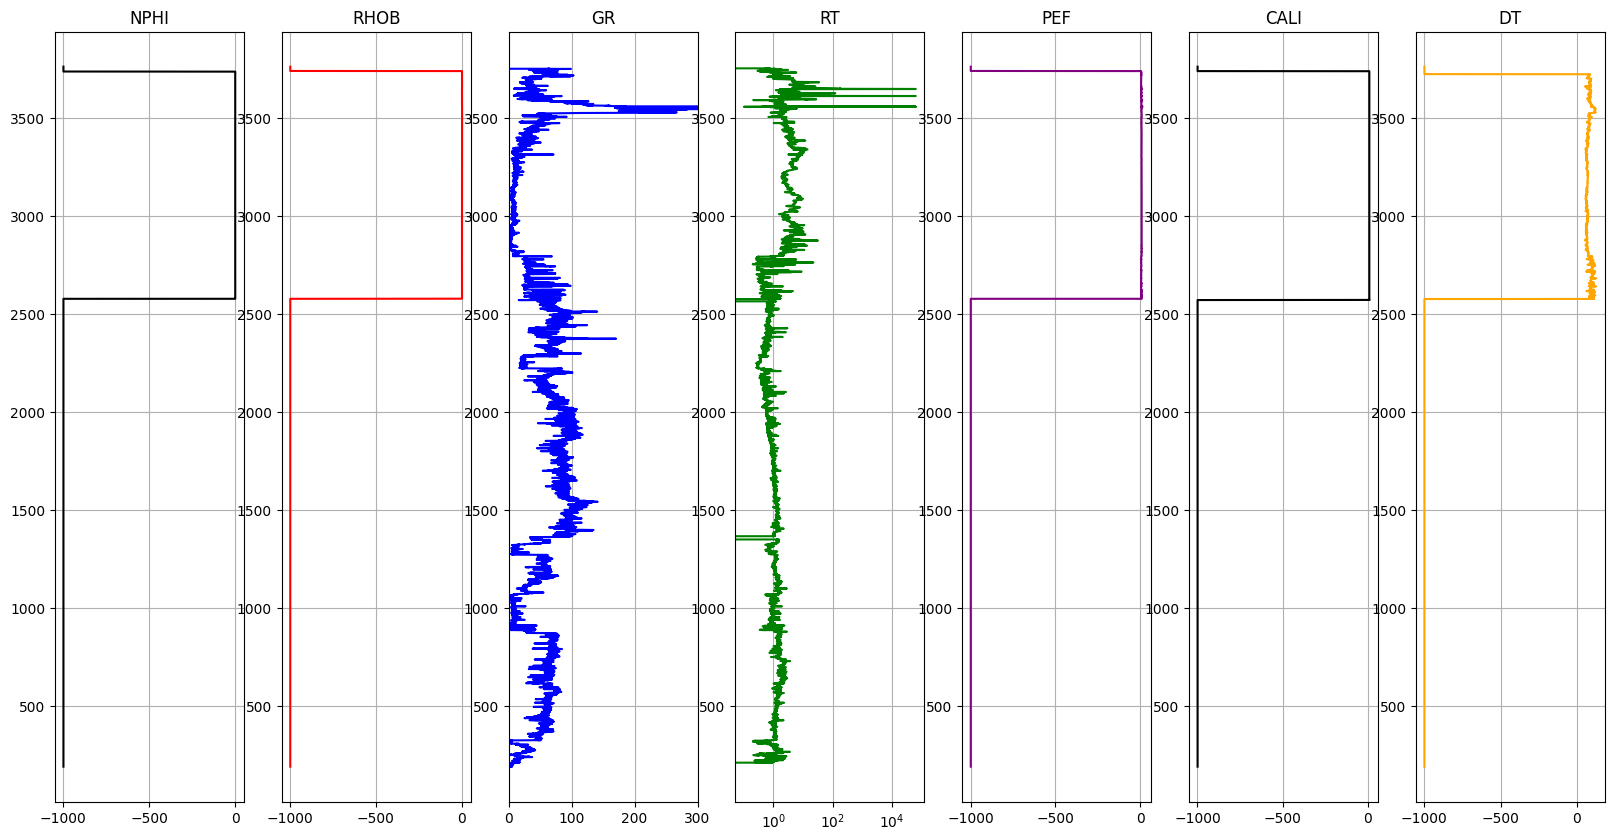

In [7]:
#lets plot the logs to see where the data lies against depth
# define what logs are we going to us
logs = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

# create the subplots; ncols equals the number of logs
fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(20,10))

# looping each log to display in the subplots

colors = ['black', 'red', 'blue', 'green', 'purple', 'black', 'orange']

for i in range(len(logs)):
  if i == 3:
    # for resistivity, semilog plot
    ax[i].semilogx(train_df[logs[i]], train_df['DEPTH'], color=colors[i])
  else:
    # for non-resistivity, normal plot
    ax[i].plot(train_df[logs[i]], train_df['DEPTH'], color=colors[i])
  
  ax[i].set_title(logs[i])
  ax[i].grid(True)

ax[2].set_xlim(0, 300)
plt.show()

In [8]:
#form the above plot, we can see that the Openhole starts at 2600m and ends at 3700m, we will limit the data accordingly
train_df = train_df[(train_df['DEPTH'] >= 2600) & (train_df['DEPTH'] <= 3700)]
train_df

NPHI   RHOB      GR     RT    PEF   CALI       DT   DEPTH
24115  0.371  2.356  82.748  1.323  7.126  8.648  104.605  2600.0
24116  0.341  2.338  79.399  1.196  6.654  8.578  103.827  2600.1
24117  0.308  2.315  74.248  1.171  6.105  8.578  102.740  2600.2
24118  0.283  2.291  68.542  1.142  5.613  8.547  100.943  2600.3
24119  0.272  2.269  60.314  1.107  5.281  8.523   98.473  2600.4
...      ...    ...     ...    ...    ...    ...      ...     ...
35111  0.238  2.233  44.975  1.596  5.624  8.672   92.589  3699.6
35112  0.240  2.234  44.635  1.604  5.592  8.672   92.838  3699.7
35113  0.242  2.234  44.137  1.600  5.568  8.672   93.151  3699.8
35114  0.242  2.234  45.796  1.581  5.578  8.648   93.588  3699.9
35115  0.243  2.233  47.207  1.575  5.631  8.672   94.005  3700.0

[11001 rows x 8 columns]

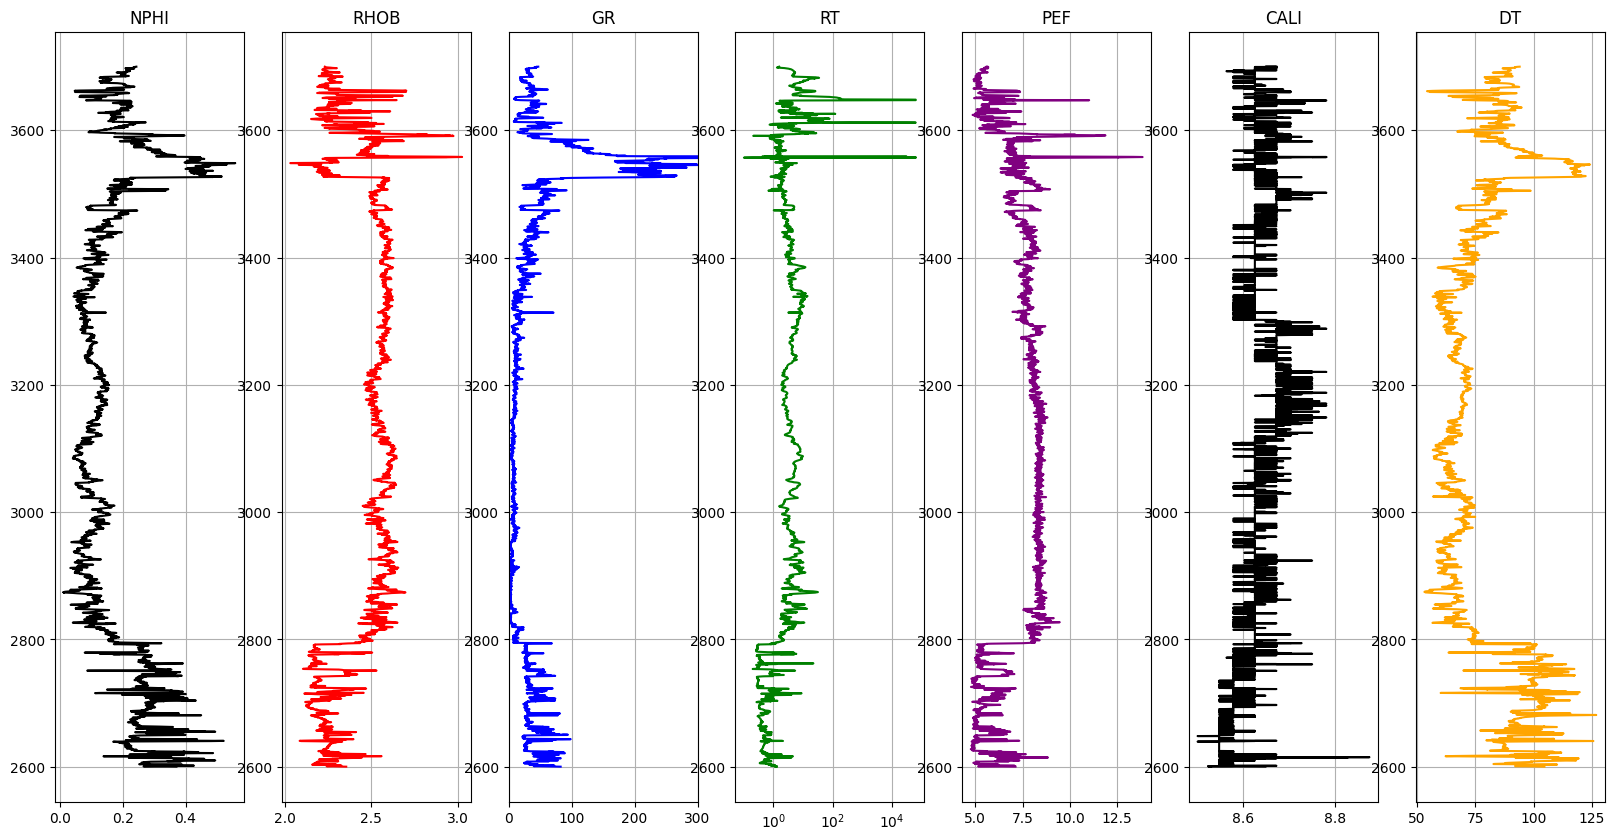

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(20,10))

# looping each log to display in the subplots

colors = ['black', 'red', 'blue', 'green', 'purple', 'black', 'orange']

for i in range(len(logs)):
  if i == 3:
    # for resistivity, semilog plot
    ax[i].semilogx(train_df[logs[i]], train_df['DEPTH'], color=colors[i])
  else:
    # for non-resistivity, normal plot
    ax[i].plot(train_df[logs[i]], train_df['DEPTH'], color=colors[i])
  
  ax[i].set_title(logs[i])
  ax[i].grid(True)

ax[2].set_xlim(0, 300)
plt.show()

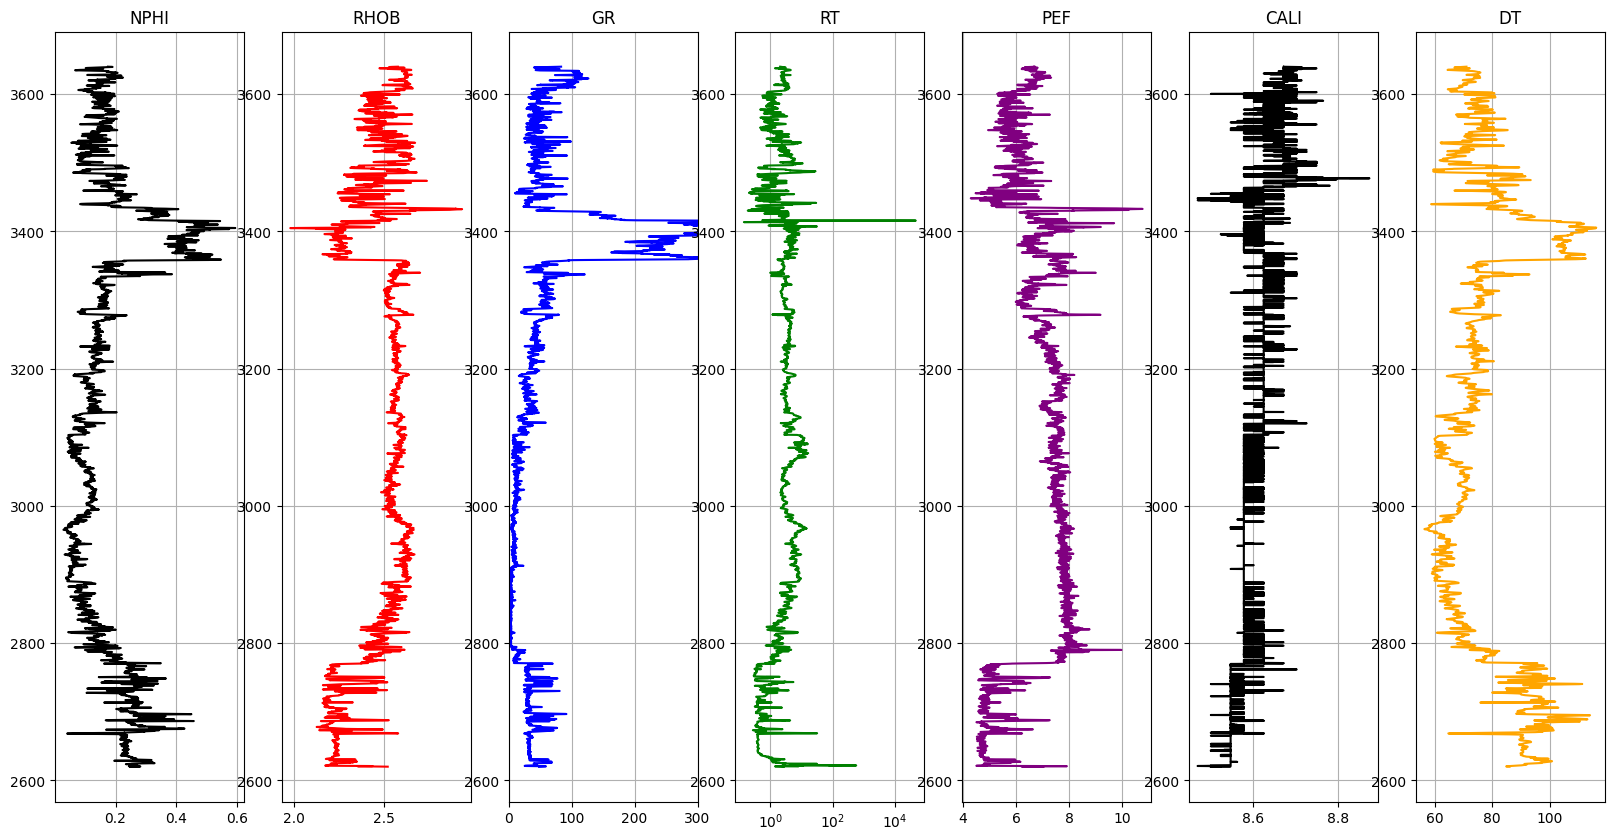

In [10]:
#similarly we found the range of test data and prediction data
test_df = test_df[(test_df['DEPTH'] >= 2620) & (test_df['DEPTH'] <= 3640)]

fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(20,10))

# looping each log to display in the subplots

colors = ['black', 'red', 'blue', 'green', 'purple', 'black', 'orange']

for i in range(len(logs)):
  if i == 3:
    # for resistivity, semilog plot
    ax[i].semilogx(test_df[logs[i]], test_df['DEPTH'], color=colors[i])
  else:
    # for non-resistivity, normal plot
    ax[i].plot(test_df[logs[i]], test_df['DEPTH'], color=colors[i])
  
  ax[i].set_title(logs[i])
  ax[i].grid(True)

ax[2].set_xlim(0, 300)
plt.show()


In [11]:
#now lets do some data exploration

#check for nulls
train_df.isnull().sum()

NPHI     0
RHOB     0
GR       0
RT       0
PEF      0
CALI     0
DT       0
DEPTH    0
dtype: int64

In [12]:
test_df.isnull().sum()

NPHI     0
RHOB     0
GR       0
RT       0
PEF      0
CALI     0
DT       0
DEPTH    0
dtype: int64

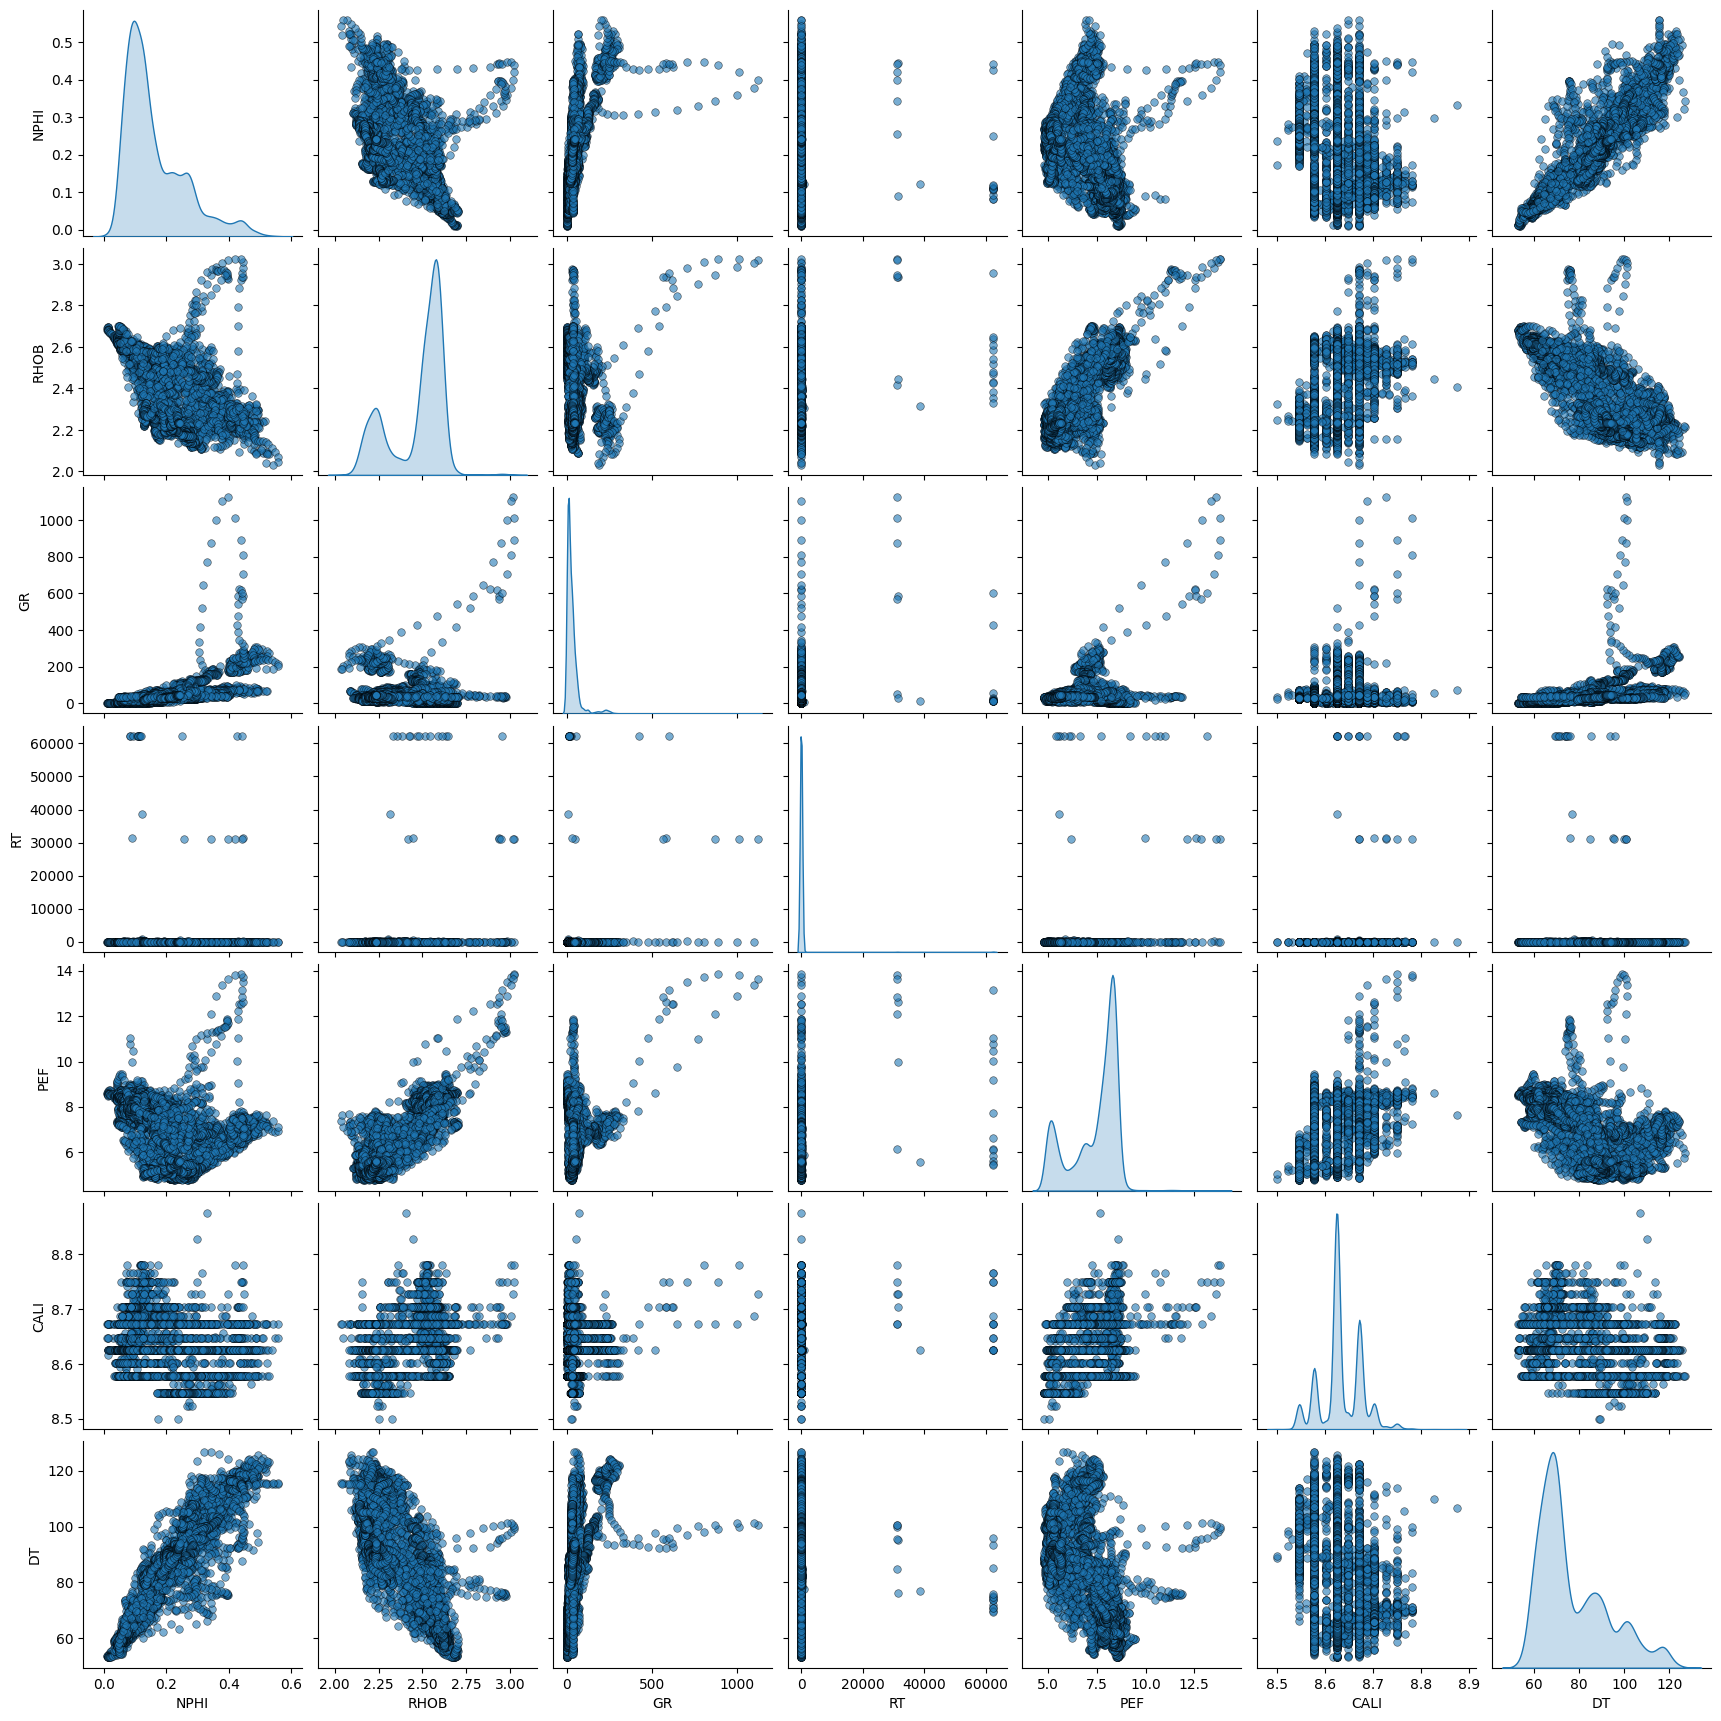

In [13]:
#since we dont have any nulls, now lets look into some visualizations
sns.pairplot(train_df.drop(columns=['DEPTH']), diag_kind='kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'}) 

<Axes: >

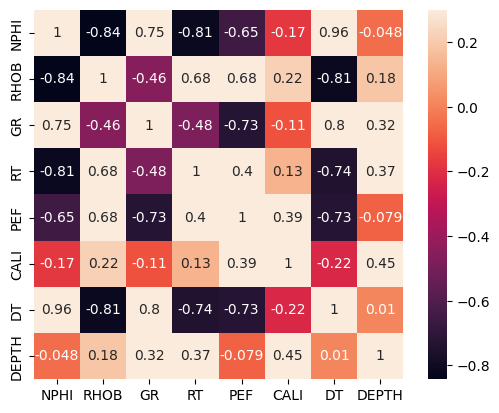

In [14]:
#from the pairplots it is clear that the distribution is not normal/gaussian and we have to normalize the data
#now lets find the correlation between the features
sns.heatmap(train_df.corr(method = 'spearman') ,annot=True,  vmax=.3, square=True)


In [15]:
#from correlation we can see that DT is tightly correlated with most of the features
#now we will normalize the data for both test and train dfs but before we need to Log transform the resistivity data because it is measured in ohm.m and it is a log scale

train_df['RT']= np.log10(train_df['RT']) 
test_df['RT']= np.log10(test_df['RT']) 

# we will use power transform with Yeo-Johnson method to normalize the data
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer(method='yeo-johnson')
ct = ColumnTransformer([('transform', scaler, ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT'])], remainder='passthrough')

#fit the transformer
transformer = ct.fit(train_df)



In [16]:
train_df_transformed = pd.DataFrame(transformer.transform(train_df), columns=train_df.columns)




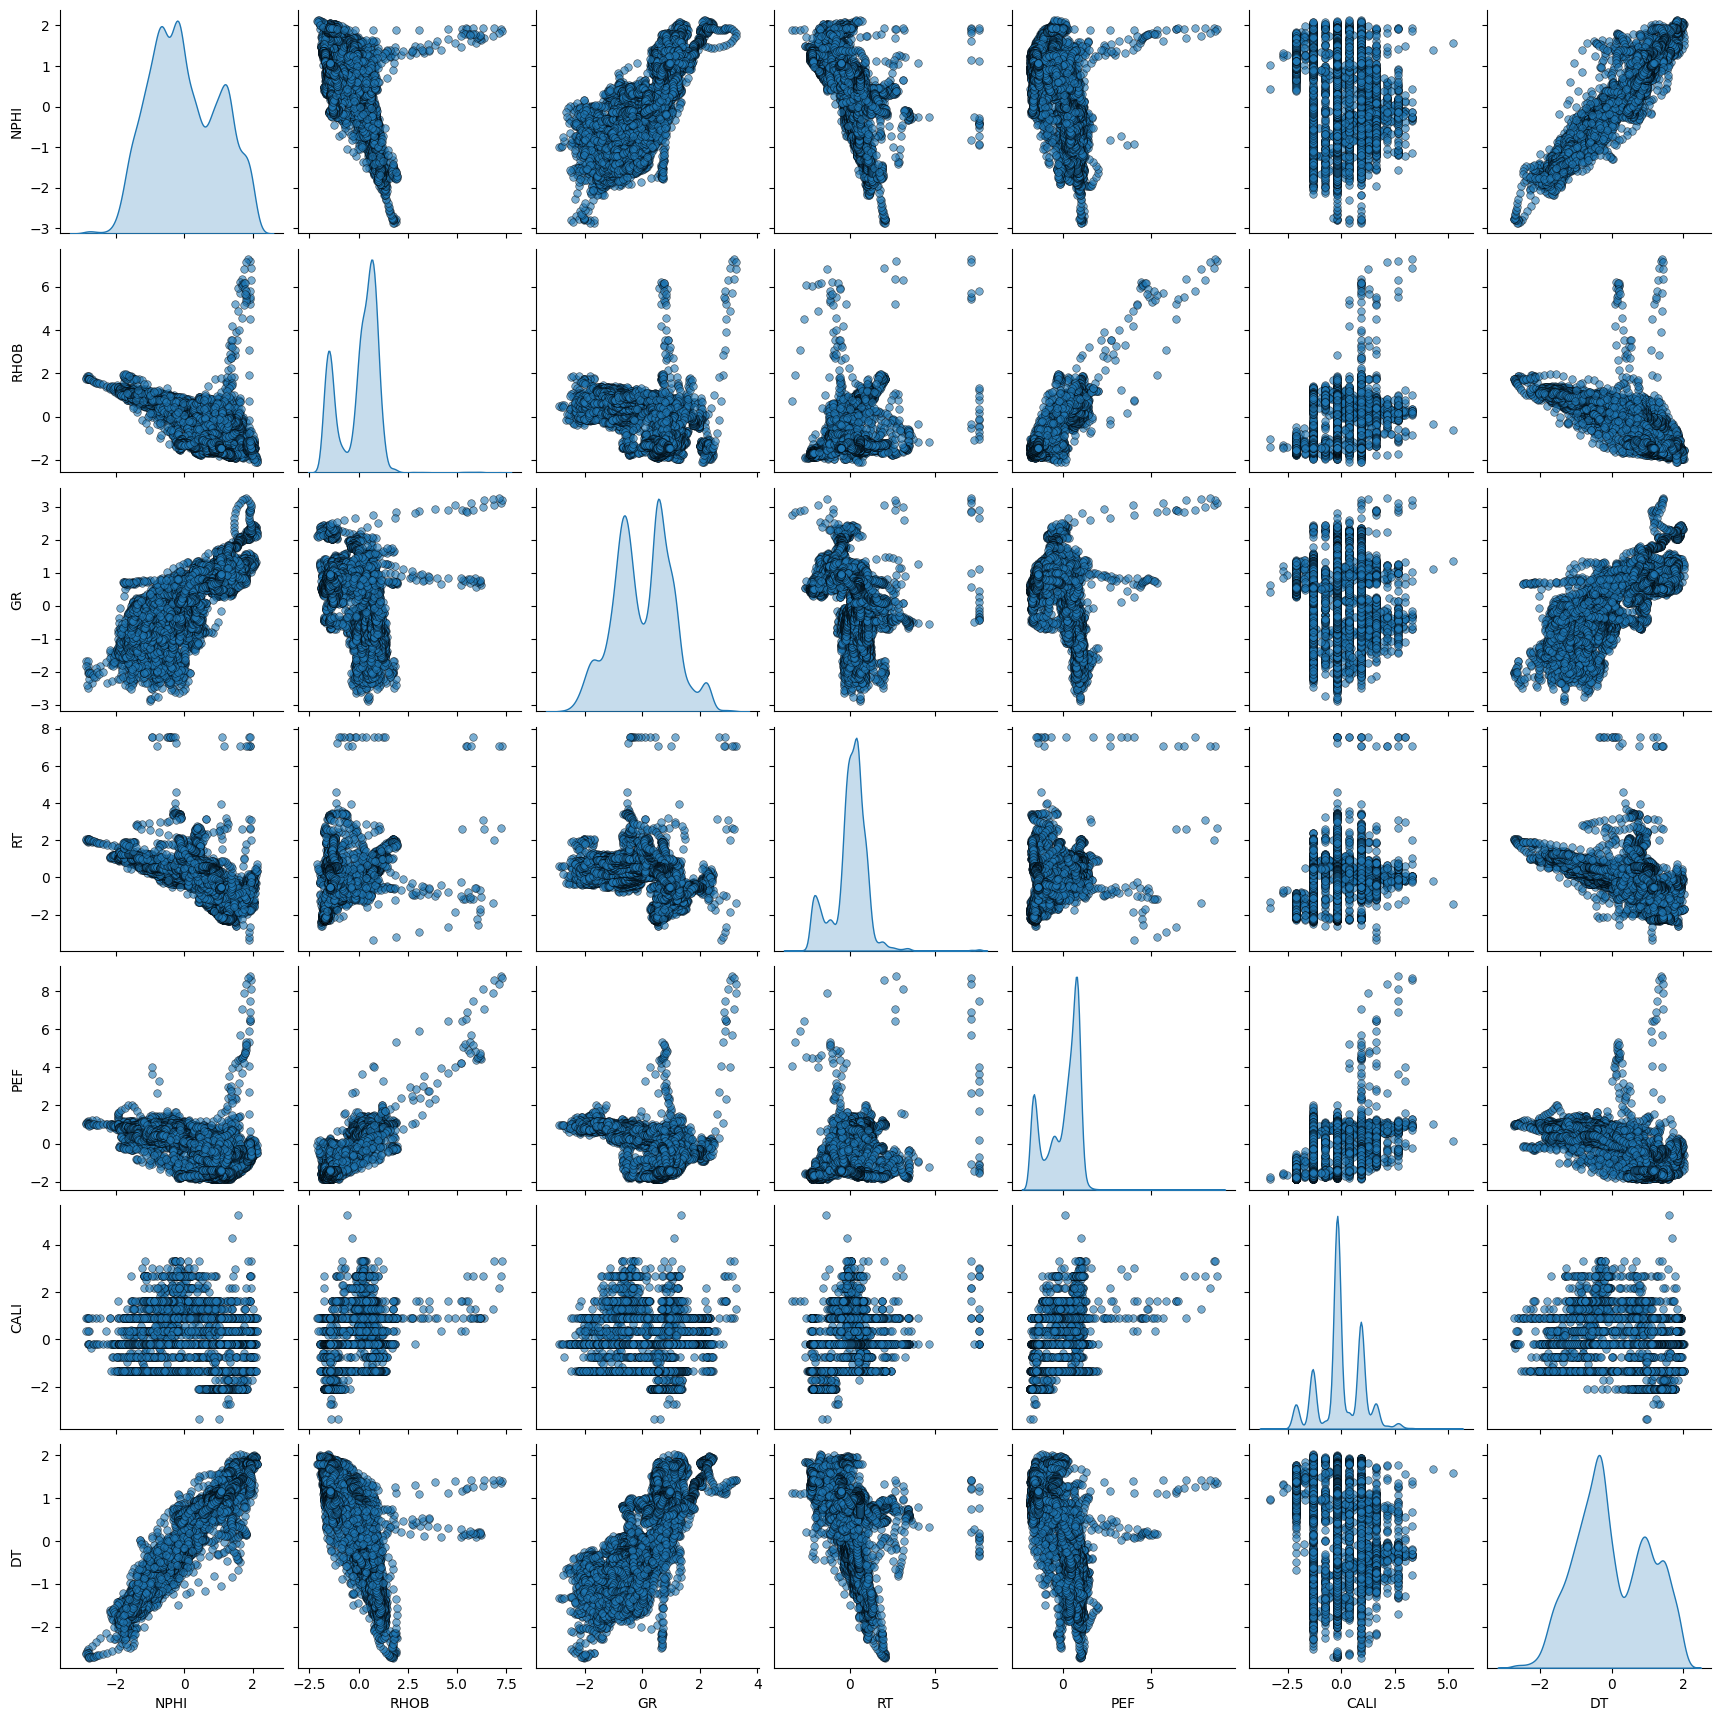

In [17]:
sns.pairplot(train_df_transformed.drop(columns=['DEPTH']), diag_kind='kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'}) 

In [18]:
#remove outliers
# as we can see from the pairplot there are some outliers that needs to be removes. These usually come from the noise in the data or bad borehole conditions.
# we will use OneClassSVM to remove the outliers

from sklearn.svm import OneClassSVM
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(train_df_transformed.drop(columns=['DEPTH']))
mask = yhat != -1
train_df_transformed_outlier_removed = train_df_transformed[mask]

In [19]:
train_df_transformed_outlier_removed.head(100)

NPHI      RHOB        GR        RT       PEF      CALI        DT  \
0    1.720664 -0.891033  1.452705 -0.680876 -0.317073  0.359175  1.538764   
1    1.607761 -0.986604  1.418317 -0.777994 -0.689511 -1.338061  1.515983   
2    1.459560 -1.103009  1.362065 -0.798433 -1.083628 -1.338061  1.483296   
3    1.327084 -1.217936  1.294318 -0.822747 -1.402115 -2.121853  1.426956   
8    1.366134 -1.403943  0.819965 -0.786113 -1.408868 -1.866798  1.102540   
..        ...       ...       ...       ...       ...       ...       ...   
119  1.744432 -1.441426  1.087206 -1.515455 -1.052190 -1.338061  1.639247   
120  1.819398 -1.420703  1.156291 -1.502914 -0.977248 -1.714784  1.648593   
121  1.898039 -1.395503  1.230270 -1.444240 -0.826958 -1.338061  1.659540   
122  1.950196 -1.361334  1.261963 -1.390559 -0.645438 -1.338061  1.677348   
123  1.965582 -1.330895  1.283919 -1.353348 -0.491422 -1.338061  1.699274   

      DEPTH  
0    2600.0  
1    2600.1  
2    2600.2  
3    2600.3  
8    2600.8  
..      ...  
119  2611.9  
120  2612.0  
121  2612.1  
122  2612.2  
123  2612.3  

[100 rows x 8 columns]

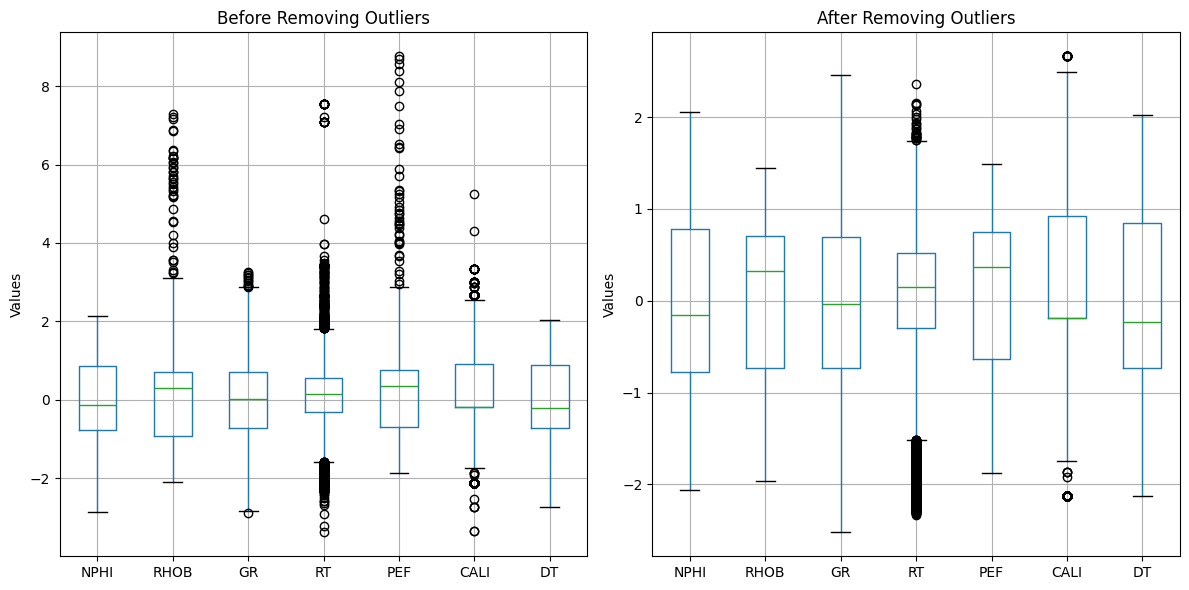

In [20]:
#lets see the distribution of data before and after removing the outliers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # figsize controls the size of the entire figure

train_df_transformed.drop(columns=['DEPTH']).boxplot(ax=ax1)
ax1.set_title('Before Removing Outliers')
ax1.set_ylabel('Values')

train_df_transformed_outlier_removed.drop(columns=['DEPTH']).boxplot(ax=ax2)
ax2.set_title('After Removing Outliers')
ax2.set_ylabel('Values')

plt.tight_layout()  
plt.show()  

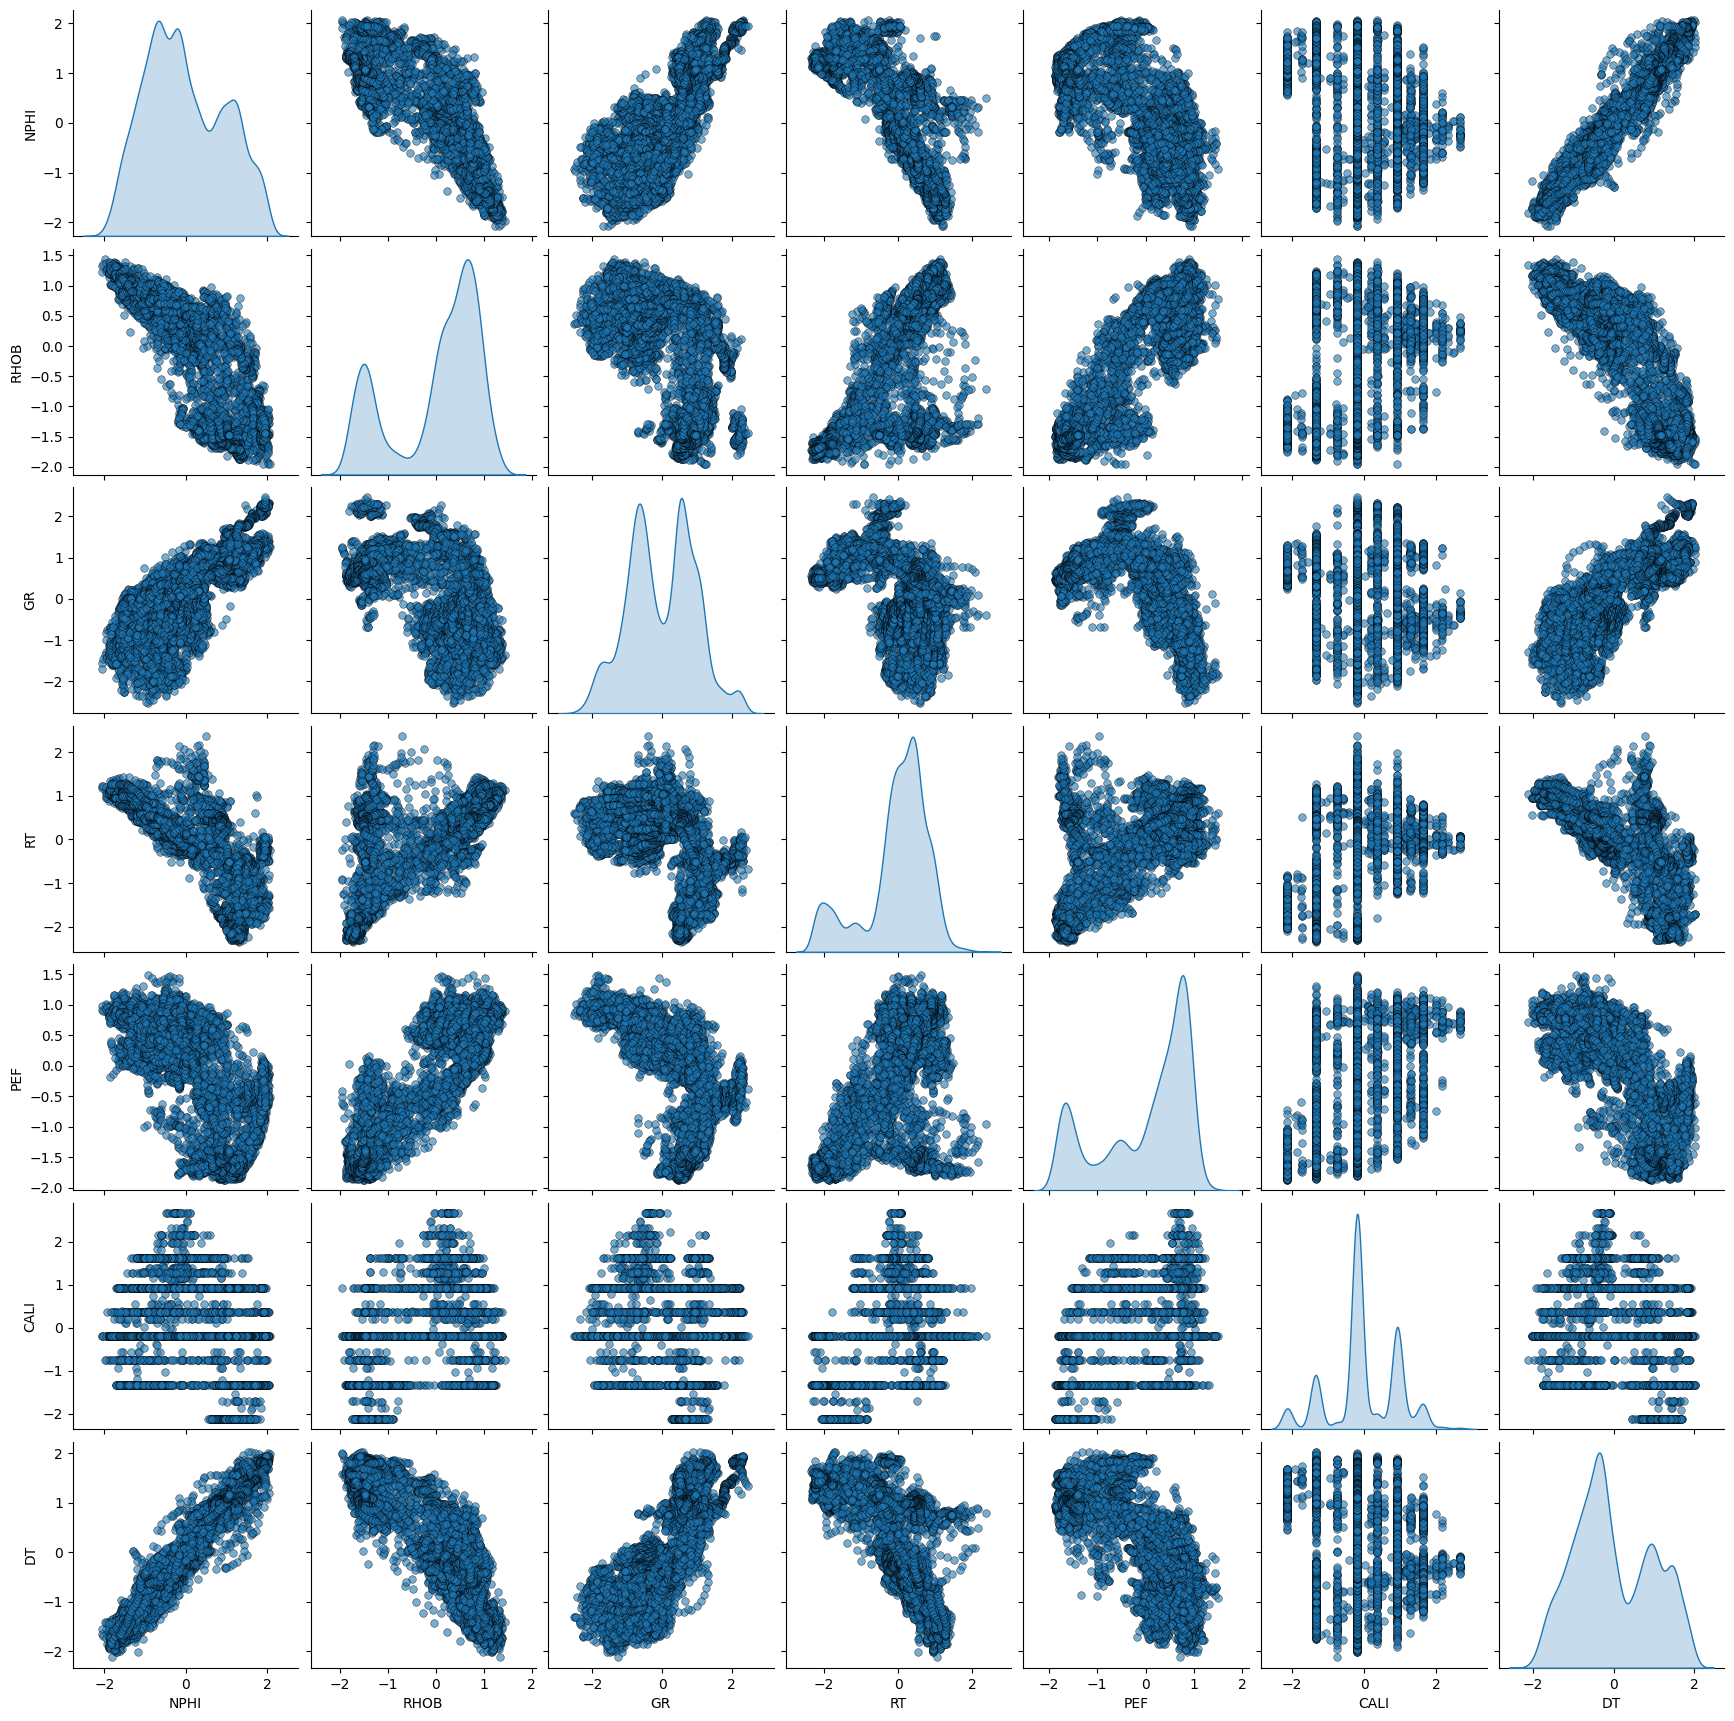

In [21]:
#lets see the pairplot again
sns.pairplot(train_df_transformed_outlier_removed.drop(columns=['DEPTH']), diag_kind='kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'}) 

In [22]:
#now the data looks much cleaner. Lets start with prediction modelling.
#since I have tried many models, I am going to start with XGBoost

X_train = train_df_transformed_outlier_removed.drop(columns=['DEPTH', 'DT'])
y_train = train_df_transformed_outlier_removed['DT']

import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
#now we transform our test data set and make predictions
test_df_transformed = transformer.transform(test_df)
test_df_transformed = pd.DataFrame(test_df_transformed, columns=test_df.columns)
test_df_transformed

NPHI      RHOB        GR        RT       PEF      CALI        DT  \
0      1.105036  0.187117  0.991708 -0.019896 -0.397727 -3.346953  0.818174   
1      1.195307  0.058911  1.050380 -0.020234 -0.627370 -2.734917  0.791675   
2      1.295849 -0.159660  1.079173 -0.120787 -0.858443 -3.349617  0.777416   
3      1.317932 -0.405551  1.099769 -0.219876 -1.014918 -3.346953  0.763033   
4      1.250789 -0.645300  1.119930 -0.414693 -0.979001 -2.126976  0.755977   
...         ...       ...       ...       ...       ...       ...       ...   
10196  0.621020  0.296540  1.319177 -0.112921 -0.759869  1.274376 -0.363213   
10197  0.604947  0.366940  1.355205 -0.143578 -0.693666  0.916490 -0.323974   
10198  0.563012  0.472525  1.384680 -0.174080 -0.648722  0.916490 -0.285573   
10199  0.507163  0.581071  1.408406 -0.217279 -0.640776  0.916490 -0.247867   
10200  0.463748  0.656006  1.459724 -0.257179 -0.668217  0.918798 -0.214778   

        DEPTH  
0      2620.0  
1      2620.1  
2      2620.2  
3      2620.3  
4      2620.4  
...       ...  
10196  3639.6  
10197  3639.7  
10198  3639.8  
10199  3639.9  
10200  3640.0  

[10201 rows x 8 columns]

In [24]:
y_pred = model.predict(test_df_transformed.drop(columns=['DEPTH', 'DT']))


In [33]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(test_df_transformed['DT'], y_pred))
r2 = r2_score(test_df_transformed['DT'], y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R^2 score: {r2:.2f}")


RMSE: 0.31
R^2 score: 0.87


In [36]:
#lets do some hyperparameter tuning
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

param_grid = {
    'learning_rate': [0.1, 0.2],  
    'max_depth': [3, 5],         
    'n_estimators': [100, 200]   
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   5.7s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   3.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   4.3s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   7.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  11.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  12.5s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  13.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  15.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  13.4s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=  18.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=  19.0s
[CV] END ...learning_rate=0.1, max_depth=5, n_est

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [39]:
#this is our best model from grid search
best_xgb_model = grid_search.best_estimator_


In [40]:
y_pred2 = best_xgb_model.predict(test_df_transformed.drop(columns=['DEPTH', 'DT']))

rmse = np.sqrt(mean_squared_error(test_df_transformed['DT'], y_pred2))
r2 = r2_score(test_df_transformed['DT'], y_pred2)

print(f"RMSE: {rmse:.2f}")
print(f"R^2 score: {r2:.2f}")

RMSE: 0.29
R^2 score: 0.89


In [41]:
#we now have slightly better evaluation metrics. You can try adding more parameters and range to the grid
#now that we have prediction, lets compare them side by side
df_compare = pd.DataFrame({'Actual DT' : test_df_transformed['DT'], 'Predicted DT without tuning' : y_pred, 'Predicted DT with tuning' : y_pred, 'Depth' : test_df_transformed['DEPTH']})
df_compare.head()

Actual DT  Predicted DT without tuning  Predicted DT with tuning   Depth
0   0.818174                     0.565194                  0.565194  2620.0
1   0.791675                     0.824314                  0.824314  2620.1
2   0.777416                     1.259203                  1.259203  2620.2
3   0.763033                     1.286063                  1.286063  2620.3
4   0.755977                     1.286394                  1.286394  2620.4

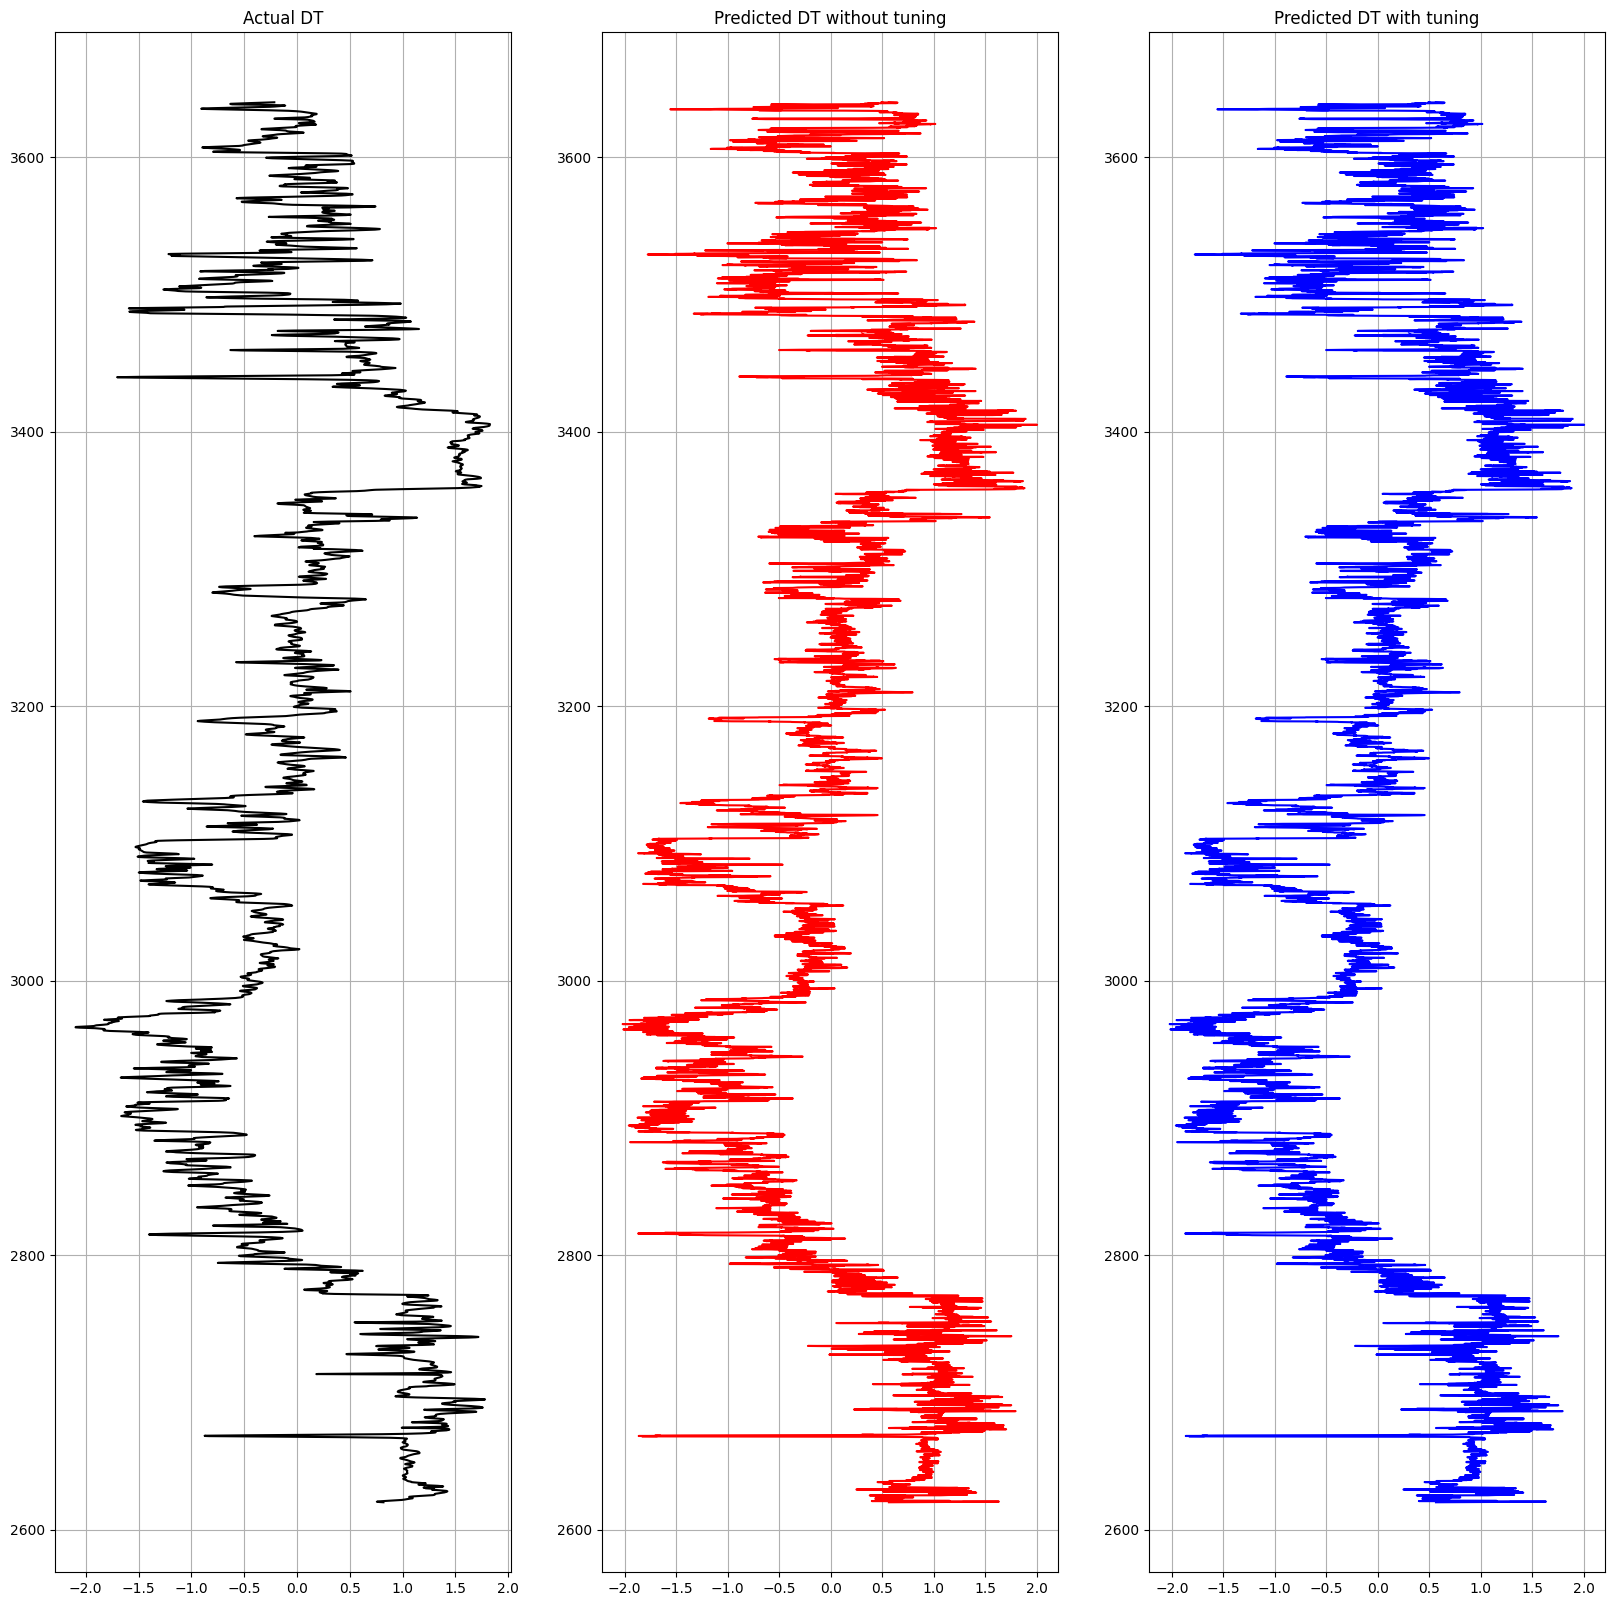

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,20))

# looping each log to display in the subplots

colors = ['black', 'red', 'blue']

for i in range(3):
    ax[i].plot(df_compare[df_compare.columns[i]], df_compare['Depth'], color=colors[i])
    ax[i].set_title(df_compare.columns[i])
    ax[i].grid(True)

plt.show()